Wishlist:
1. Allow study of duplications and inversions, i.e. preserving exons as they are with incorporation of duplication stretches and inversions inside or outside of the transcript.

TODO:
5. Setting new start and end in all HSPs (new zero, new `qlen` for RNA reconstruction, `slen` => from input or last `send` in HSPs regarding query).

In [1]:
import matplotlib.pyplot as plt

In [29]:
class HSP:
    """
    High-scoring pair from BLAST alignment representing
    an alignment block.
    """
    orientation_dict = {(True, True): 'direct',
                        (True, False): 'reverse',
                       }
    def __init__(self, qstart, qend, sstart, send, score, **kwargs):
        """
        Constructor.
        
        Args:
            qstart (int): start of HSP in query sequence.
            qend (int): end of HSP in query sequence.
            sstart (int): start of HSP in subject sequence.
            send (int): end of HSP in subject sequence.
        """
        self.qstart = qstart
        self.qend = qend
        self.sstart = sstart
        self.send = send
        self.score = score
        self.kwargs = kwargs
        self.qstrand = self.qend - self.qstart > 0
        self.sstrand = self.send - self.sstart > 0
        self.orientation = self.orientation_dict.get((self.qstrand, self.sstrand))
    
    def __repr__(self):
        kwargs_repr = self.kwargs.__repr__()
        params_list = [str(i)
                       for i in (self.qstart,
                                 self.qend,
                                 self.sstart,
                                 self.send)] + ["**" + kwargs_repr]
        return f"HSP({', '.join(params_list)})"
    
    def __str__(self):
        return f"q {self.qstart}:{self.qend} s {self.sstart}:{self.send} {self.orientation}"

    def precede(self, other):
        """Infers HSP precedence.

        Infers whether self HSP precedes other HSP
        in both query and subject sequence.
        
        Returns:
            True if self precedes other, False otherwise.
        
        Raises:
            ValueError in case of inconsisting orientations.
            Precedence is defined only for HSPs of same
            orientation (except for None orientation).
        """
        if (self.orientation != other.orientation and
            (self.orientation is not None) and
            (other.orientation is not None)):
            raise ValueError(f"HSPs have inconsisting orientations: "
                             f"{self.orientation} for {self} and "
                             f"{other.orientation} for {other}.")
        qprecede = self.qend < other.qstart
        if self.orientation == 'direct' or other.orientation == 'direct':
            sprecede = self.send < other.sstart
        else:
            sprecede = self.send > other.sstart
        if qprecede and sprecede:
            return True
        return False
    
    def distance(self, other, gapopen=5, gapextend=2):
        """Calculates distance between two HSPs.
        
        Distance between two HSPs of same orientation
        is calculated as sum of distances in query and
        subject sequence multiplied by gap extension
        penalty added with gap opening penalty and
        subtracted with the score of the following HSP.
        In case none HSP precedes the other one (overlap
        or different, non-sequential placement) the
        distance is set to infinity.
        
        Args:
            self: HSP instance;
            other: HSP instance;
            gapopen (int): penalty for gap opening;
            gapextend (int): penalty for gap extension.
        
        Returns:
            An int/float or Inf in case none HSP precedes
            the other one.
        
        Raises:
            ValueError in case of inconsisting orientations.
            Distance is defined only for HSPs of same
            orientation (except for None orientation).
        """
        if (self.orientation != other.orientation and
            (self.orientation is not None) and
            (other.orientation is not None)):
            raise ValueError(f"HSPs have inconsisting orientations: "
                             f"{self.orientation} for {self} and "
                             f"{other.orientation} for {other}.")
        if self.precede(other):
            qdist = other.qstart - self.qend
            if self.orientation == 'direct' or other.orientation == 'direct':
                sdist = other.sstart - self.send
            else:
                sdist = self.send - other.sstart
            return gapopen + gapextend * (qdist + sdist) - other.score
        elif other.precede(self):
            qdist = self.qstart - other.qend
            if self.orientation == 'direct' or other.orientation == 'direct':
                sdist = self.sstart - other.send
            else:
                sdist = other.send - self.sstart
            return gapopen + gapextend * (qdist + sdist) - self.score
        else:  # doesn't distinguish between overlap and different placement
            return float("Inf")
        

    def to_dict(self):
        """Returns a dict representation."""
        return self.__dict__

    @staticmethod
    def from_dict(dict_):
        """Recovers from a dict representation."""
        keys = ['qstart', 'qend', 'sstart', 'send', 'score']
        return HSP(*[dict_.get(key, None) for key in keys],
                   **dict_.get('kwargs', dict()))

    def copy(self):
        """Returns a copy of an instance.
        
        All dynamic data in HSPVertex will be lost!
        """
        return HSP(self.qstart, self.qend, self.sstart, self.send, self.score, **self.kwargs)

In [3]:
a = HSP(1, 10, 2, 12, 15, sex='male')

In [4]:
a_dict = a.to_dict()
a_new = HSP.from_dict(a_dict)

In [5]:
class HSPVertex(HSP):
    """
    An extension of HSP class for handling graph operations
    (contains a list of neighbours).
    """
    def __init__(self, qstart, qend, sstart, send, score, **kwargs):
        """
        Constructor.
        
        Args:
            qstart (int): start of HSP in query sequence.
            qend (int): end of HSP in query sequence.
            sstart (int): start of HSP in subject sequence.
            send (int): end of HSP in subject sequence.
        """
        super().__init__(qstart, qend, sstart, send, score, **kwargs)
        self.next_vertices = []
        self.total_score = float("Inf")
        self.best_prev = None
    
    def __repr__(self):
        kwargs_repr = self.kwargs.__repr__()
        params_list = [str(i) for i in (self.qstart, self.qend, self.sstart, self.send)] + ["**" + kwargs_repr]
        return f"HSPVertex({', '.join(params_list)})"

    def __str__(self):
        next_vertices_str = "\t" + "\n\t".join(" ".join(str(i).split(" ")[:-1]) for i in self.next_vertices)
        return f"q {self.qstart}:{self.qend} s {self.sstart}:{self.send} {self.orientation}\n" + next_vertices_str
    
    def _relax(self, other, weight):
        """A relax method for dynamic programming.
        
        If the current path from the begin vertex
        to self vertex is more expensive than the path
        that goes through the other vertex, a new cheaper
        path from the begin to self is set.
        
        Args:
            self (HSPVertex): a vertex to be relaxed,
                i.e. to minimize score of path from
                begin vertex to the vertex.
            other (HSPVertex): a vertex preceding
                and connected to self.
            weight (int, float): weight of the edge
                connecting other and self vertices.

        Returns:
            None
        """
        new_score = other.total_score + weight
        if self.total_score > new_score:
            self.total_score = new_score
            self.best_prev = other

In [6]:
class Transcript:
    """
    Transcript combined from non-overlapping
    sequential HSPs.
    
    Attributes:
        HSPs (list): a list of HSPVertex instances
            representing a sequence of homologous
            regions in query and subject sequences;
        alignment (Alignment): corresponding
            `Alignment` instance;
        score (int, float): a transcript score
            computed as HSPs scores minus gap
            penalties (see `set_score` and
            `HSP.distance` methods for definition).
    """
    def __init__(self, HSPs, alignment):
        """
        Constructor.
        
        Args:
            HSPs (list): a list of HSPs representing the
                transcript.
            alignment (Alignment): corresponding `Alignment`
                instance.
        """
        self.HSPs = HSPs
        self.alignment = alignment
        self.score = self.set_score()
    
    def set_score(self):
        """Calculates transcript score.
        
        The transcript score is based on alignment
        score and gap penalties defined by distance
        function.
        
        Returns:
            Transcript score.
        """
        if self.HSPs:
            score = self.HSPs[0].score
        else:
            return - float('inf')
        for i in range(len(self.HSPs) - 1):
            score -= self.HSPs[i].distance(self.HSPs[i + 1])
        return score
    
    def __str__(self):
        header = "qstart\tqend\tsstart\tsend"
        lines = ['\t'.join(str(_) for _ in [hsp.qstart, hsp.qend, hsp.sstart, hsp.send]) for hsp in self.HSPs]
        return "\n".join([header] + lines)
    
    def __repr__(self):
        return f"Transcript({repr(self.HSPs)})"
    
    def plot_transcript(self, color='red', link_color='blue'):
        """Plots transcript with corresponding alignment.

        First plots corresponding alignment in black, then
        transcripts's HSPs with solid lines and connections
        between them with dashed lines.
        
        Args:
            color (str): a color name to plot transcript's
                HSPs;
            link_color (str): a color name to plot connections
                between transcript's HSPs.
        
        Returns:
            None
        """
        self.alignment.plot_alignment()
        for hsp in self.HSPs:
            plt.plot([hsp.qstart, hsp.qend], [hsp.sstart, hsp.send], color=color)
        for i in range(len(self.HSPs) - 1):
            plt.plot([self.HSPs[i].qend, self.HSPs[i + 1].qstart],
                     [self.HSPs[i].send, self.HSPs[i + 1].sstart],
                     color=link_color,
                     linestyle='dashed',
                    )

In [7]:
def is_float(string):
    """Checks whether a string represent a float number."""
    try:
        _ = float(string)
        return True
    except ValueError:
        return False


def numberize(string):
    """String to number if possible.
    
    Transforms string to float or to
    integer if possible.
    
    Returns:
        int, float or str instance.
    """
    if is_float(string):
        a = float(string)
        if a.is_integer():
            return int(a)
        else:
            return a
    else:
        return string

In [8]:
class Alignment:
    """BLAST alignment of two sequences.
    
    Represents a BLAST alignment of two sequences
   (NOT an alignment of a sequence against a database!).
    Contains a list of HSPs and other additional information.
    Allows to read BLAST alignment from file produced with
    `-outfmt 7`, plot an alignment map, read from and write to
    dictionary representation (hence, JSON) and find best
    transcripts based on some strategies.    
    
    Attributes:
        _all_HSPs (list): list of all HSPs related
            to the alignment;
        HSPs (list): list of HSP instances that were
            filtered by some criterion;
        qlen (int): length of query sequence;
        slen (int): length of subject sequence;
        replace_dict (dict): field names to replace
            for convenience.    
    """
    replace_dict = {'q. start': 'qstart',
                    'q. end': 'qend',
                    's. start': 'sstart',
                    's. end': 'send',
                    'query length': 'qlen',
                    'subject length': 'slen',
                   }


    def __init__(self, HSPs, qlen, slen, filtered_HSPs=None):
        """Constructor.
        
        Args:
            HSPs (list): list of HSP instances;
            qlen (int): query sequence length;
            slen (int): subject sequence length;
            filtered_HSPs (list): list of HSP instances
                that were filtered by some criterion
               (default: None).
        """
        self._all_HSPs = HSPs
        self.HSPs = HSPs.copy() if filtered_HSPs is None else filtered_HSPs
        self.qlen = qlen
        self.slen = slen
        self.filtered = False if filtered_HSPs is None else True


    def __repr__(self):
        return f"Alignment({self.HSPs.__repr__()}, {self.qlen}, {self.slen})"


    def __str__(self):
        return f"Alignment of {self.qlen} and {self.slen}\n" + "\n".join(hsp.__str__() for hsp in self.HSPs)

    
    def plot_alignment(self, qleft=None, qright=None, sleft=None, sright=None):
        """Plots alignment map."""
        for hsp in self.HSPs:
            plt.plot([hsp.qstart, hsp.qend], [hsp.sstart, hsp.send], color='black')
        for hsp in set(self._all_HSPs) - set(self.HSPs):
            plt.plot([hsp.qstart, hsp.qend], [hsp.sstart, hsp.send], color='grey')
        plt.xlim(qleft, qright)
        plt.ylim(sleft, sright)
        plt.xlabel("Query")
        plt.ylabel("Subject")


    @staticmethod
    def from_file(file_object):
        """File parser.
        
        Takes file object that corresponds to
        a BLAST alignment of two sequences
        produced with `-outfmt 7` key and
        parses it into an Alignment object.
        
        Args:
            file_object: file object.
        
        Returns:
            An Alignment instance.
        """
        line = file_object.readline()

        while not line.startswith("# Fields:"):
            line = file_object.readline()

        fields = line.lstrip("# Fields: ").rstrip("\n").split(", ")
        fields = [Alignment.replace_dict.get(item, item)
                  for item in fields]
        hit_number = int(file_object.readline().split(" ")[1])
        HSPs = list()
        for i in range(hit_number):
            hsp = file_object.readline().strip().split("\t")
            hsp = [numberize(item) for item in hsp]
            hsp = HSPVertex(**dict(zip(fields, hsp)))
            HSPs.append(hsp)
        return Alignment(HSPs, hsp.kwargs['qlen'], hsp.kwargs['slen'])
    
    def to_dict(self):
        """Transforms instance to dict representation."""
        keys = ['HSPs', 'qlen', 'slen', 'filtered_HSPs', 'filtered']
        HSPs = [hsp.to_dict() for hsp in self._all_HSPs]
        filtered_HSPs = [hsp.to_dict() for hsp in self.HSPs]
        return dict(zip(keys, [HSPs, self.qlen, self.slen, filtered_HSPs, self.filtered]))

    @staticmethod
    def from_dict(dict_):
        """Restores object from dict representation."""
        keys = ['qlen', 'slen']
        HSPs = [HSPVertex.from_dict(item)
                for item in dict_.get('HSPs', [])]
        qlen = dict_.get('qlen')
        slen = dict_.get('slen')
        if dict_.get('filtered_HSPs') is None:
            filtered_HSPs = None
        else:
            filtered_HSPs = [HSPVertex.from_dict(item)
                             for item in dict_.get('filtered_HSPs')]
        return Alignment(HSPs, qlen, slen, filtered_HSPs)
    
    def filter_by_score(self, score):
        """Filters HSPs by score.

        All HSPs being stored in `self._all_HSPs`,
        the method puts those HSPs in `self.HSPs`
        that have score greater than `score`.

        Args:
            self: Alignment instance;
            score: score to filter by.

        Returns:
            None
        """
        self.HSPs = [hsp for hsp in self._all_HSPs if hsp.score > score]
        self.filtered = True
    
    def reset_filter(self):
        """Resets HSP filtering."""
        self.HSPs = [hsp for hsp in self._all_HSPs]
        self.filtered = False
    
    def set_zero(self, qzero, szero):
        """Sets new query and subject sequence beginnings.
        
        Given coordinates of the current query and subject
        sequence beginnnings in the new coordinates,
        transforms all HSP coordinates accordingly. Returns
        new Alignment instance, filtration and graph data
        will be lost. Use before filtering and graph building.
        
        Args:
            qzero (int): the location of the current query
                sequence beginning in the new coordinates.
            szero (int): the location of the current subject
                sequence beginning in the new coordinates.
        
        Returns:
            Alignment instance with new HSP coordinates
            and new qlen and slen.
        """
        qlen = self.qlen + qzero
        slen = self.slen + szero
        HSPs = list()
        for hsp in self._all_HSPs:
            new_hsp = hsp.copy()
            new_hsp.qstart += qzero
            new_hsp.qend += qzero
            new_hsp.sstart += szero
            new_hsp.send += szero
            HSPs.append(new_hsp)
        return Alignment(HSPs, qlen, slen)
    
    def _split_orientations(self):
        """Splits HSPs in two groups by orientation."""
        sorted_hsps = sorted(self.HSPs,
                             key=lambda hsp: (hsp.orientation,
                                              hsp.qstart,
                                              hsp.sstart))
        oriented_groups = {'direct': [],
                           'reverse': [],
                          }
        for hsp in sorted_hsps:
            oriented_groups[hsp.orientation].append(hsp)
        return oriented_groups

    def _build_hsp_graph(self, vertices, orientation):
        """Builds graph from HSP list.

        Taken sorted list of HSPVertex instances
        adds succeeding HSPs in `next_vertices` attribute so
        as these HSPs are the closest to the given
       (only one if it does not overlap any other HSP,
        more than one otherwise). Check the code and
        `HSP.precede` for complete definition.
        
        Args:
            vertices (list): a list of HSPVertex instances
                of one direction sorted by qstart.
                
        Returns:
            a new list of HSPVertex instances.        
        """
        # Add begin and end nodes.
        if orientation == 'direct':
            begin = HSPVertex(*[0 for _ in range(5)])
            end = HSPVertex(self.qlen,
                            self.qlen,
                            self.slen,
                            self.slen,
                            0)
        else:
            begin = HSPVertex(0, 0, self.slen, self.slen, 0)
            end = HSPVertex(self.qlen, self.qlen, 0, 0, 0)
        vertices = [begin] + vertices + [end]
        # Join all those vertex pairs where one
        # vertex precedes the other one.
        for i in range(len(vertices)):
            vertices[i].next_vertices = list()
            vertices[i].best_prev = None
            vertices[i].total_score = 0 if i == 0 else float("Inf")
            for j in range(i + 1, len(vertices)):
                if vertices[i].precede(vertices[j]):
                    vertices[i].next_vertices.append([vertices[j],
                                                      vertices[i].distance(vertices[j])])
        # Leave only those edges that connect each vertex
        # with its direct preceder(s).
        for vertex in vertices:
            i = 0
            k = 1
            while k < len(vertex.next_vertices):
                if vertex.next_vertices[i][0].precede(vertex.next_vertices[k][0]):
                    vertex.next_vertices = vertex.next_vertices[:k]
                else:
                    k += 1
        
        return vertices

    def _find_all_transcripts(self, vertices, orientation):
        """
        Build all possible transcripts from given list
        of HSPs so that HSPs follow each other on both
        query and subject sequences and do not overlap
        with each other.

        Args:
            vertices (list): a list of HSP instances
                sorted by query start and query end.

        Returns:
            list of all possible transcripts.
        """
        if len(vertices) == 0:
            return []
        vertices = self._build_hsp_graph(vertices, orientation)
        stack = list()
        transcripts = list()
        stack.append([vertices[0]])
        while stack:
            if stack[-1][-1].next_vertices:
                nascent_transcript = stack.pop()
                for neighbour, weight in nascent_transcript[-1].next_vertices:
                    stack.append(nascent_transcript + [neighbour])
            else:
                transcripts.append(Transcript(stack.pop()[1:-1], self))
        return transcripts

    def get_all_transcripts(self):
        """Finds all possible transcripts from HSPs.
        
        Finds all possible transcripts consisting of
        consecutive non-overlapping HSPs in both
        query and subject sequences in two orientations:
        * direct, i.e. HSP is aimed from start towards
            end in both query and subject sequences;
        * reverse, i.e. from start to end in query
            sequence but from end to start
            in subject sequence.

        Note:
            Very greedy -- exponential on number of HSPs.
            Use only with few HSPs.
        
        Returns:
            dictionary containing lists of transcripts
            in direct and reverse orientation.
        """
        oriented_groups = self._split_orientations()
        return {key: self._find_all_transcripts(group, key)
                for key, group in oriented_groups.items()}
    
    def _find_best_transcript(self, vertices, orientation):
        """Finds best transcript in given HSP list.
        
        Utilizes dynamic programming algorithm of finding
        the shortest path between two graph vertices to
        get a sequence of HSPs with lowest total distance score.
        Distance score is defined by `HSP.distance` method when
        building the graph with `_build_hsp_graph` method.
            
        Args:
            vertices (list): list of HSPVertex instances
                produced by `_split_orientations` method
               (i.e. of one orientation and sorted by qstart
                and sstart);
            orientation (str): one of 'direct', 'reverse'.
        
        Returns:
            A Transcript instance with the best score.
        """
        if len(vertices) == 0:
            return Transcript([], self)
        vertices = self._build_hsp_graph(vertices, orientation)
        for vertex in vertices:
            for neighbour, weight in vertex.next_vertices:
                neighbour._relax(vertex, weight)
        current_vertex = vertices[-1]
        best_hsps = list()
        while current_vertex.best_prev is not None:
            best_hsps.append(current_vertex)
            current_vertex = current_vertex.best_prev
        return Transcript(best_hsps[1:][::-1], self)

    def get_best_transcripts(self):
        """Finds best transcripts.
        
        Finds best transcripts in direct
        and reverse HSP orientation with
        dynamic programming approach (i.e.
        minimizing gap penalties between HSPs.)
        
        Returns:
            dict with best direct and reverse
            Transcript instance under 'direct'
            and 'reverse' keys, respectively.
        """
        oriented_groups = self._split_orientations()
        return {key: self._find_best_transcript(group, key)
                for key, group in oriented_groups.items()}

In [9]:
with open("sample_align.tsv", 'r') as infile:
    align = Alignment.from_file(infile)

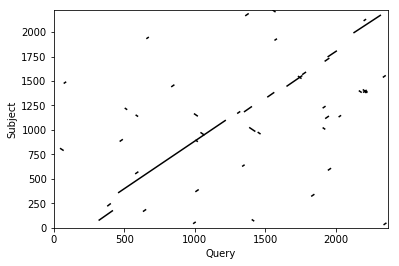

In [10]:
align.plot_alignment()

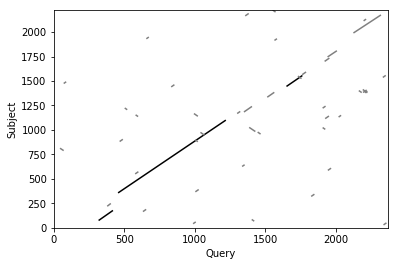

In [12]:
align.filter_by_score(50)
align.plot_alignment()

In [13]:
align_transcripts = align.get_all_transcripts()

In [14]:
{key: len(item) for key, item in align_transcripts.items()}

{'direct': 1, 'reverse': 0}

In [15]:
best_transcripts = align.get_best_transcripts()

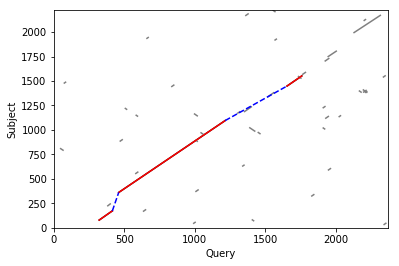

In [16]:
best_transcripts['direct'].plot_transcript()

In [17]:
hsp_data = [[1, 10, 2, 11, 10],
            [8, 10, 47, 55, 15],
            [8, 15, 5, 12, 10],
            [20, 25, 13, 18, 15],
            [27, 30, 22, 24, 10],
            [35, 40, 30, 36, 15],
            [38, 45, 36, 47, 10],
            [42, 48, 40, 47, 15],
            [50, 55, 50, 55, 10],
            [54, 70, 66, 72, 15],
           ]

In [18]:
vertices = [HSPVertex(*i) for i in hsp_data]

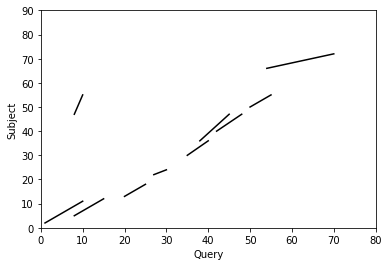

In [19]:
alignment = Alignment(vertices, 80, 90)
alignment.plot_alignment()

In [20]:
alignment.get_best_transcripts()

{'direct': Transcript([HSPVertex(1, 10, 2, 11, **{}), HSPVertex(20, 25, 13, 18, **{}), HSPVertex(27, 30, 22, 24, **{}), HSPVertex(35, 40, 30, 36, **{}), HSPVertex(42, 48, 40, 47, **{}), HSPVertex(54, 70, 66, 72, **{})]),
 'reverse': Transcript([])}

In [21]:
for hsp in alignment.HSPs:
    print(hsp.total_score, hsp.best_prev, sep='\n')

1
q 0:0 s 0:0 None
	[HSPVertex(1, 10, 2, 11, **{}),
	[HSPVertex(8, 15, 5, 12, **{}),
	[HSPVertex(8, 10, 47, 55, **{}),
100
q 0:0 s 0:0 None
	[HSPVertex(1, 10, 2, 11, **{}),
	[HSPVertex(8, 15, 5, 12, **{}),
	[HSPVertex(8, 10, 47, 55, **{}),
21
q 0:0 s 0:0 None
	[HSPVertex(1, 10, 2, 11, **{}),
	[HSPVertex(8, 15, 5, 12, **{}),
	[HSPVertex(8, 10, 47, 55, **{}),
15
q 1:10 s 2:11 direct
	[HSPVertex(20, 25, 13, 18, **{}),
22
q 20:25 s 13:18 direct
	[HSPVertex(27, 30, 22, 24, **{}),
34
q 27:30 s 22:24 direct
	[HSPVertex(35, 40, 30, 36, **{}),
	[HSPVertex(38, 45, 36, 47, **{}),
57
q 27:30 s 22:24 direct
	[HSPVertex(35, 40, 30, 36, **{}),
	[HSPVertex(38, 45, 36, 47, **{}),
36
q 35:40 s 30:36 direct
	[HSPVertex(42, 48, 40, 47, **{}),
41
q 42:48 s 40:47 direct
	[HSPVertex(50, 55, 50, 55, **{}),
	[HSPVertex(54, 70, 66, 72, **{}),
76
q 42:48 s 40:47 direct
	[HSPVertex(50, 55, 50, 55, **{}),
	[HSPVertex(54, 70, 66, 72, **{}),
